# Project 

In [0]:
!pip install vaderSentiment

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import datetime
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.metrics import accuracy_score
# trying different models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

#sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# The following line is needed to show plots inline in notebooks
%matplotlib inline 

In [0]:
url = 'https://firebasestorage.googleapis.com/v0/b/mie1624-ass2.appspot.com/o/train.csv?alt=media&token=6ecb90c4-9387-47f9-87a7-5dcbc249683d'
data = pd.read_csv(url)

In [0]:
data.head()

,Unnamed: 0,claim,claimant,date,id,label,related_articles,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,0,A line from George Orwell's novel 1984 predict...,NaN,17/07/2017,0,0,"[122094, 122580, 130685, 134765]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Maine legislature candidate Leslie Gibson insu...,NaN,17/03/2018,1,2,"[106868, 127320, 128060]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,A 17-year-old girl named Alyssa Carson is bein...,NaN,18/07/2018,4,1,"[132130, 132132, 149722]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,In 1988 author Roald Dahl penned an open lette...,NaN,04/02/2019,5,2,"[123254, 123418, 127464]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,22/03/2016,6,2,"[41099, 89899, 72543, 82644, 95344, 88361]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
data.shape

(15555, 16)

## Data Cleaning

In [0]:
data = data[data.columns.drop(data.filter(regex='Unnamed').columns)]

### Claimant

In [0]:
# There are 4962 missing values in claimant
missing_claim = data[data['claimant'].isna()]
missing_claim.shape[0]

4981

In [0]:
# Of the claimant missing, how many are false-0, partly true-1, true-2?
missing_data = data[data['claimant'].isna()]
missing_data.label.value_counts(normalize=True)
# roughly 87% of claims with missing claimants are not completely true

0    0.611414
1    0.259326
2    0.129260
Name: label, dtype: float64

In [0]:
# fill missing claimants with "unknown"
data['claimant'] = data['claimant'].fillna('Unknown')

In [0]:
claimant_count = data['claimant'].value_counts()

In [0]:
# Group together all counts less than 100 in to Others
value_mask = data.claimant.isin(claimant_count.index[claimant_count < 5]) 
data.loc[value_mask,'claimant'] = "Other"
# data.claimant.value_counts()

### Date

In [0]:
# 5% of data happen on 2 separate days, November 6th 2017 and October 23rd 2016
date_count = data['date'].value_counts()

In [0]:
# On average, about 5 claims happen a day
data.date.value_counts().mean()

5.125742574257425

In [0]:
# Convert date column to datetime format
data['new_date'] = pd.to_datetime(data['date'], dayfirst=True, errors='coerce')

In [0]:
idx = data[data['new_date'].isnull()].index
print (idx)

Int64Index([  435,   526,   710,  1003,  1061,  1747,  2810,  2890,  3455,
             3644,  4204,  4311,  4635,  5821,  5862,  6230,  6403,  6882,
             7667,  8227,  8966,  9148,  9371,  9819, 11435, 12001, 12313,
            13132, 13134, 13148, 13948, 14013, 14271, 14599, 14825],
           dtype='int64')


In [0]:
data = data[np.isfinite(data['new_date'])]

In [0]:
# # sort by Date (earliest (May 6th, 1986) to latest (April 30th, 2019))
# data.sort_values(by = 'new_date')

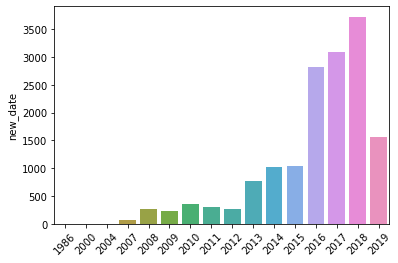

In [0]:
# claims per year
sns.barplot(x=data['new_date'].dt.year.value_counts().index, y=data['new_date'].dt.year.value_counts())
plt.xticks(rotation=45)
plt.show()

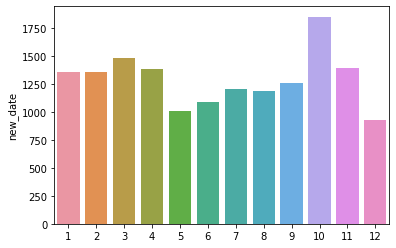

In [0]:
# Claims per month
sns.barplot(x=data['new_date'].dt.month.value_counts().index, y=data['new_date'].dt.month.value_counts())
plt.show()

In [0]:
# fake/real claims per month
month = data[data['new_date'].dt.year == 2018]
month.label.value_counts()

0    2102
1    1243
2     378
Name: label, dtype: int64

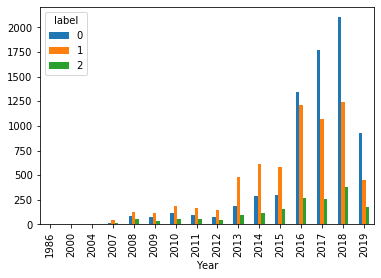

In [0]:
# Plot labels against each year
data['Year'] = data['new_date'].apply(lambda x: "%d" % (x.year))
year_label = data.groupby(['Year', 'label']).size().unstack(fill_value=0)
year_label.plot.bar()

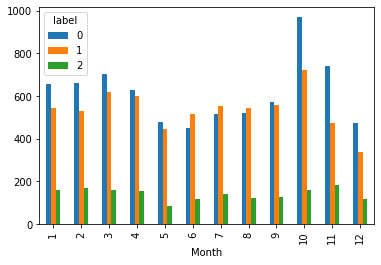

In [0]:
# Plot labels against each month
data['Month'] = data['new_date'].apply(lambda x: "%d" % (x.month))
month_label = data.groupby(['Month', 'label']).size().unstack(fill_value=0)
# For some reason, have to reorder the month index by adding a new column
month_order = [1, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8, 9]
month_label['month'] = month_order
month_label = month_label.sort_values(by=['month'])
# Dropping the added column as it is not needed after reordering
month_label = month_label.drop(['month'], axis=1)
month_label.plot.bar()

In [0]:
# fake_data = data[data['label'] == 0]
# fake_data_month = fake_data[fake_data['new_date'].dt.month==10]
# fake_data_month.label.value_counts()

In [0]:
# # Created a month dataframe
# month_index = data['new_date'].dt.month.value_counts().index.tolist()
# month_count = data['new_date'].dt.month.value_counts().tolist()
# month_data = pd.DataFrame(columns=['Month', 'Count'])
# month_data['Month'] = month_index
# month_data['Count'] = month_count
# month_data

In [0]:
# # Group together all counts less than average in to Others
# value_mask = data.date.isin(date_count.index[date_count < 5]) 
# data.loc[value_mask,'date'] = "Other"
# # data.date.value_counts()

### Related Articles 

In [0]:
# related articles is of type object
data.dtypes

claim                       object
claimant                    object
date                        object
id                          object
label                       object
related_articles            object
new_date            datetime64[ns]
Year                        object
Month                       object
dtype: object

In [0]:
data.columns.get_loc('related_articles')

5

In [0]:
# related articles are in str format
value = data.iloc[0][6]
type(value)

pandas._libs.tslibs.timestamps.Timestamp

In [0]:
# function to convert strings to numpy array
def str2array(value):
    str_list = re.findall(r'\d+', value)
    int_list = list(map(int, str_list))
    article_array = np.array(int_list)
    return article_array

In [0]:
data['article_array'] = data['related_articles'].apply(str2array)

In [0]:
data.columns.get_loc('article_array')

9

In [0]:
value = data.iloc[0][7]
type(value)

str

In [0]:
data['related_article_text'] = ''

**Note**: Uncomment text below to pull related article text from local folder and read into the dataframe - I couldn't make this work on my computer. 
Once the text is in the dataframe and cleaned, the sentiment analyzer is coded below and will provide scores for the article text and plots will be created to visualize article sentiment and then article vs. claim sentiment. 

In [0]:
# import os
# os.chdir(os.getcwd() + '\train_articles')

In [0]:
# # Importing related article text to 'data' dataframe 
# for i in range(len(data)):
#     for j in range(len(data.iloc[i, 7])):
#         f=open(str(data.iloc[i, 7][j])+'.txt', "r")
#         if f.mode == 'r':
#             contents =f.read()
#             data.at[i, 'related_article_text'] = data.iloc[i, -1]+''+contents
#         f.close()

In [0]:
# to clean up related article text
# stemmer = SnowballStemmer("english")
# from IPython.display import clear_output, display
# tokenizer = RegexpTokenizer(r'\w+') #Splits up the words
# stop_words = set(stopwords.words('english'))
# related_article_text_clean = [] 
# i=0
# for text in data['related_article_text']:
# #     snip = re.sub(r'\d+', '', text) #remove numeric
#     words = tokenizer.tokenize(text)
#     words = [w.lower() for w in words] #lowercase  
#     words = [w for w in words if not w in stop_words] #remove stop words
#     words = [stemmer.stem(w) for w in words] #stemming
    
#     sentence = ' '.join(word for word in words)
#     related_article_text_clean.append(sentence)
#     i+=1
#     clear_output(wait=True)
#     print(round((i/len(data))*100, 2))

In [0]:
# data.at['related_article_text'] = pd.Series(related_article_text_clean)

##Sentiment Analysis

In [0]:
data.head()

,claim,claimant,date,id,label,related_articles,new_date,Year,Month,article_array
0,A line from George Orwell's novel 1984 predict...,Unknown,17/07/2017,0,0,"[122094, 122580, 130685, 134765]",2017-07-17,2017,7,"[122094, 122580, 130685, 134765]"
1,Maine legislature candidate Leslie Gibson insu...,Unknown,17/03/2018,1,2,"[106868, 127320, 128060]",2018-03-17,2018,3,"[106868, 127320, 128060]"
2,A 17-year-old girl named Alyssa Carson is bein...,Unknown,18/07/2018,4,1,"[132130, 132132, 149722]",2018-07-18,2018,7,"[132130, 132132, 149722]"
3,In 1988 author Roald Dahl penned an open lette...,Unknown,04/02/2019,5,2,"[123254, 123418, 127464]",2019-02-04,2019,2,"[123254, 123418, 127464]"
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,22/03/2016,6,2,"[41099, 89899, 72543, 82644, 95344, 88361]",2016-03-22,2016,3,"[41099, 89899, 72543, 82644, 95344, 88361]"


In [0]:
sentiment = SentimentIntensityAnalyzer()

In [0]:
vs_compound = []
vs_pos = []
vs_neu = []
vs_neg = []

In [0]:
# data.iloc[0]['claim']

"A line from George Orwell's novel 1984 predicts the power of smartphones."

In [0]:
#applying the sentiment analyzer to the claim text
for i in range(0, len(data)):
    vs_compound.append(sentiment.polarity_scores(data.iloc[i]['claim'])['compound'])
    vs_pos.append(sentiment.polarity_scores(data.iloc[i]['claim'])['pos'])
    vs_neu.append(sentiment.polarity_scores(data.iloc[i]['claim'])['neu'])
    vs_neg.append(sentiment.polarity_scores(data.iloc[i]['claim'])['neg'])

In [0]:
#creating new columns with the claim sentiment scores
data['overall'] = vs_compound
data['positive'] = vs_pos
data['neutral'] = vs_neu
data['negative'] = vs_neg

In [0]:
data.sample(n=10)

,claim,claimant,date,id,label,related_articles,new_date,Year,Month,article_array,overall,positive,neutral,negative
3692,"Minecraft has a newly-discovered ""sex mod"" of ...",Unknown,28/02/2018,4066,1,"[107993, 123303, 124612]",2018-02-28,2018,2,"[107993, 123303, 124612]",-0.3818,0.000,0.890,0.110
10636,A zeppelin airship flew over Giza in Egypt in ...,Unknown,28/03/2019,11721,2,"[143275, 148362, 149998, 150007]",2019-03-28,2019,3,"[143275, 148362, 149998, 150007]",0.0000,0.000,1.000,0.000
9748,Pampers Dry Max diapers commonly cause severe ...,Unknown,19/04/2018,10753,0,"[116821, 123290, 154070]",2018-04-19,2018,4,"[116821, 123290, 154070]",-0.6486,0.000,0.694,0.306
3857,South Africa’s President Ramaphosa dancing lik...,Unknown,28/03/2019,4251,0,"[100910, 98478, 100573]",2019-03-28,2019,3,"[100910, 98478, 100573]",0.3612,0.238,0.762,0.000
3839,"""Kesha Rogers is not a Democrat.""",Other,25/02/2014,4229,0,"[72147, 16209, 15448, 16034]",2014-02-25,2014,2,"[72147, 16209, 15448, 16034]",0.0000,0.000,1.000,0.000
4865,"President Obama called Libya a ""Shit Show"" and...",Unknown,15/01/2018,5356,1,"[115024, 119992, 132240, 144076, 150516, 15166...",2018-01-15,2018,1,"[115024, 119992, 132240, 144076, 150516, 15166...",-0.7096,0.000,0.629,0.371
10361,"Charlie Crist ""raised taxes in 2009 and won't ...",Republican Party of Florida,02/04/2014,11423,1,"[73184, 5764, 93148]",2014-04-02,2014,4,"[73184, 5764, 93148]",0.0000,0.000,1.000,0.000
997,"""We now have longitudinal data that shows that...",Cory Booker,29/04/2019,1087,1,"[44509, 13053, 29488, 29489, 36404, 36393, 444...",2019-04-29,2019,4,"[44509, 13053, 29488, 29489, 36404, 36393, 444...",-0.4019,0.000,0.899,0.101
3963,"The Russia investigation ""was a coup. This was...",Donald Trump,25/04/2019,4368,0,"[51029, 51030, 60651]",2019-04-25,2019,4,"[51029, 51030, 60651]",0.4215,0.167,0.833,0.000
6309,Portugal doesn't have net neutrality regulatio...,Unknown,14/12/2017,6933,1,"[106894, 110684, 119772, 142382, 145426, 15016...",2017-12-14,2017,12,"[106894, 110684, 119772, 142382, 145426, 15016...",0.0000,0.000,1.000,0.000


In [0]:
#copy of the data frame with just sentiments and labels for visualization
df_sent = pd.DataFrame()
df_sent = data[['label','overall','positive','neutral','negative']].copy()

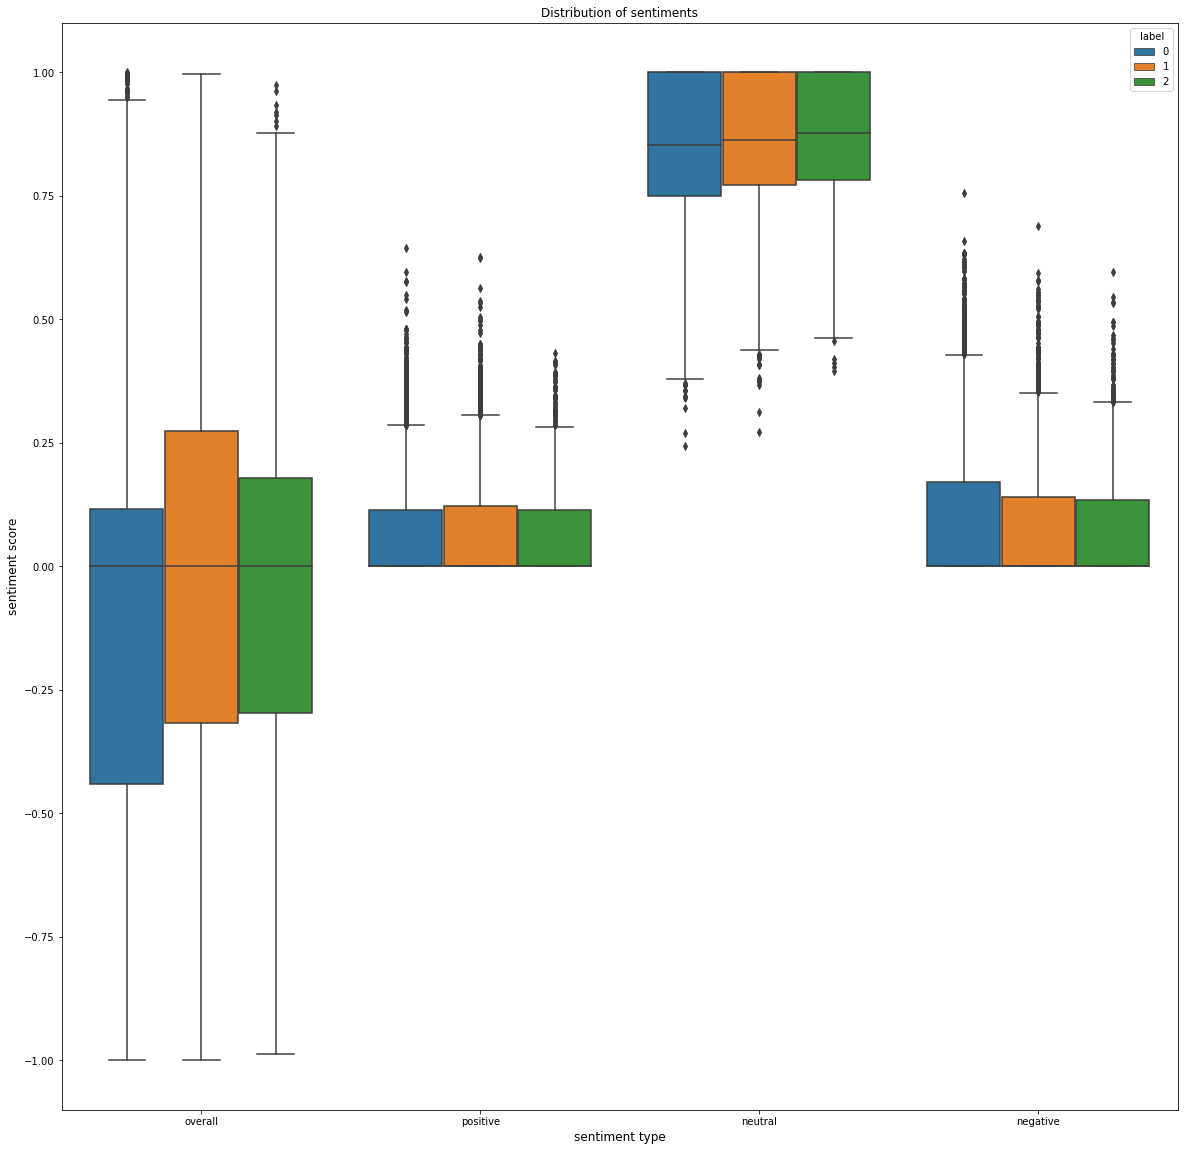

In [0]:
#box plots of the sentiment scores per label  
plt.figure(figsize=(20,20))
sns.boxplot(x="variable", y="value", hue="label", data=pd.melt(df_sent, id_vars=['label'], value_vars=['overall','positive','neutral','negative']))
plt.title('Distribution of sentiments')
plt.ylabel('sentiment score', fontsize=12)
plt.xlabel('sentiment type', fontsize=12)
plt.show()

In [0]:
#seperating dataframe for each label for plotting
false = df_sent[df_sent.label=='0']
part_true = df_sent[df_sent.label=='1']
true = df_sent[df_sent.label=='2']

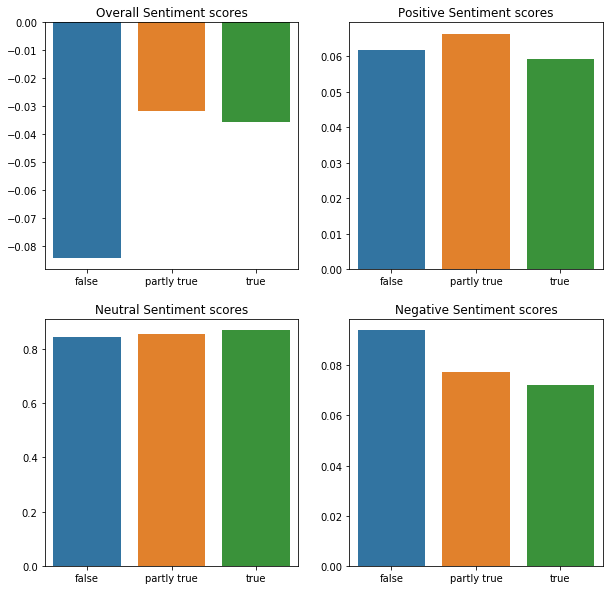

In [0]:
#plot of the average sentiment score for each label
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=False,sharey=False)
axes = axes.flatten()
ax1 = sns.barplot(x=['false', 'partly true', 'true'], y=[false['overall'].mean(), part_true['overall'].mean(), true['overall'].mean()], ax=axes[0])
ax1.set_title('Overall Sentiment scores')
ax2 = sns.barplot(x=['false', 'partly true', 'true'], y=[false['positive'].mean(), part_true['positive'].mean(), true['positive'].mean()], ax=axes[1])
ax2.set_title('Positive Sentiment scores')
ax3 = sns.barplot(x=['false', 'partly true', 'true'], y=[false['neutral'].mean(), part_true['neutral'].mean(), true['neutral'].mean()], ax=axes[2])
ax3.set_title('Neutral Sentiment scores')
ax4 = sns.barplot(x=['false', 'partly true', 'true'], y=[false['negative'].mean(), part_true['negative'].mean(), true['negative'].mean()], ax=axes[3])
ax4.set_title('Negative Sentiment scores')
plt.show()

In [0]:
vs_compound = []
vs_pos = []
vs_neu = []
vs_neg = []

In [0]:
#applying the sentiment analyzer to related article text
for i in range(0, len(data)):
    vs_compound.append(sentiment.polarity_scores(data.iloc[i]['related_article_text'])['compound'])
    vs_pos.append(sentiment.polarity_scores(data.iloc[i]['related_article_text'])['pos'])
    vs_neu.append(sentiment.polarity_scores(data.iloc[i]['related_article_text'])['neu'])
    vs_neg.append(sentiment.polarity_scores(data.iloc[i]['related_article_text'])['neg'])

In [0]:
#creating new columns with the article sentiment scores
data['art_overall'] = vs_compound
data['art_positive'] = vs_pos
data['art_neutral'] = vs_neu
data['art_negative'] = vs_neg

In [0]:
#new dataframe with just related article sentiment and label
df_art = pd.DataFrame()
df_art = data[['label','art_overall','art_positive','art_neutral','art_negative']].copy()

In [0]:
#box plots of the related article sentiment scores per label  
plt.figure(figsize=(20,20))
sns.boxplot(x="variable", y="value", hue="label", data=pd.melt(df_art, id_vars=['label'], value_vars=['art_overall','art_positive','art_neutral','art_negative']))
plt.title('Distribution of sentiments')
plt.ylabel('sentiment score', fontsize=12)
plt.xlabel('sentiment type', fontsize=12)
plt.show()

In [0]:
#seperating dataframe for each label for plotting
art_false = df_art[df_art.label=='0']
art_part_true = df_art[df_art.label=='1']
art_true = df_art[df_art.label=='2']

In [0]:
#plot of the average sentiment score for related articles for each label
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=False,sharey=False)
axes = axes.flatten()
ax1 = sns.barplot(x=['false', 'partly true', 'true'], y=[art_false['overall'].mean(), art_part_true['overall'].mean(), art_true['overall'].mean()], ax=axes[0])
ax1.set_title('Overall Sentiment scores')
ax2 = sns.barplot(x=['false', 'partly true', 'true'], y=[art_false['positive'].mean(), art_part_true['positive'].mean(), art_true['positive'].mean()], ax=axes[1])
ax2.set_title('Positive Sentiment scores')
ax3 = sns.barplot(x=['false', 'partly true', 'true'], y=[art_false['neutral'].mean(), art_part_true['neutral'].mean(), art_true['neutral'].mean()], ax=axes[2])
ax3.set_title('Neutral Sentiment scores')
ax4 = sns.barplot(x=['false', 'partly true', 'true'], y=[art_false['negative'].mean(), art_part_true['negative'].mean(), art_true['negative'].mean()], ax=axes[3])
ax4.set_title('Negative Sentiment scores')
plt.show()

In [0]:
#comparing the overall sentiment of claims and their related articles per label
N=3
ind = np.arange(N) 
width = 0.35 
plt.figure(figsize=(8,6))
plt.bar(ind, y = [art_false['art_overall'].mean(), art_part_true['art_overall'].mean(), art_true['art_overall'].mean()], width, label='Articles', color='red')
plt.bar(ind + width, y = [false['overall'].mean(), part_true['overall'].mean(), true['overall'].mean()], width, label='Claims', color='blue')

plt.ylabel('Average sentiment score')
plt.title('Overall sentiment of claims and related articles per label')

plt.xticks(ind + width / 2, ['false', 'partly true', 'true'])
plt.legend(loc='best')
plt.show()

## Encoding

### Claimant Encode

In [0]:
# Label encoding
data['claimant']=data['claimant'].astype('category')
data['claimant_cat']=data['claimant'].cat.codes
claimant_labels = dict(enumerate(data['claimant'].cat.categories))

### Claim Encode

#### CountVectorizer 

In [0]:
# vectorizer = CountVectorizer(analyzer = "word", # the feature should be made of word
#                              tokenizer = None, 
#                              preprocessor = None, 
#                              stop_words = 'english', # Remove stop words such as “the”, “a”, etc.
#                              max_features = 500)
# claim_vec = vectorizer.fit_transform(data['claim'].values.astype('U'))

In [0]:
# claim_array = claim_vec.toarray()

#### TFID

In [0]:
tf_vectorizer = TfidfVectorizer(analyzer = "word",
                                stop_words='english', 
                                max_df=0.9, # if word appeared in 70% of data then remove it
                                max_features = 500)
tf_vec = tf_vectorizer.fit_transform(data['claim'].values.astype('U'))
# print(tf_vectorizer.get_feature_names())

In [0]:
tf_claim_array = tf_vec.toarray()

### Date Encode

Methods of encoding dates:
    - Label encoding
    - One hot encode month and year
    - consecutive date encoding (how many days since a specified day)

In [0]:
# # Label encoding
# data['date']=data['date'].astype('category')
# data['date_cat']=data['date'].cat.codes
# date_labels = dict(enumerate(data['date'].cat.categories))

In [0]:
# create new feature with consecutive days since January 1st, 1986
data['start_date'] = pd.to_datetime('1986-01-01', format='%Y-%m-%d')
data['cont_days'] = (data['new_date'] - data['start_date']).dt.days
data = data.drop(['start_date'], axis=1)

In [0]:
# Convert Year and Month features in to int (instead of str before)
data['Year'] = data['Year'].astype(int)
data['Month'] = data['Month'].astype(int)

### Cleaned Data Frame

In [0]:
data.head()

,claim,claimant,date,id,label,related_articles,new_date,Year,Month,article_array,claimant_cat,cont_days
0,A line from George Orwell's novel 1984 predict...,Unknown,17/07/2017,0,0,"[122094, 122580, 130685, 134765]",2017-07-17,2017,7,"[122094, 122580, 130685, 134765]",289,11520
1,Maine legislature candidate Leslie Gibson insu...,Unknown,17/03/2018,1,2,"[106868, 127320, 128060]",2018-03-17,2018,3,"[106868, 127320, 128060]",289,11763
2,A 17-year-old girl named Alyssa Carson is bein...,Unknown,18/07/2018,4,1,"[132130, 132132, 149722]",2018-07-18,2018,7,"[132130, 132132, 149722]",289,11886
3,In 1988 author Roald Dahl penned an open lette...,Unknown,04/02/2019,5,2,"[123254, 123418, 127464]",2019-02-04,2019,2,"[123254, 123418, 127464]",289,12087
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,22/03/2016,6,2,"[41099, 89899, 72543, 82644, 95344, 88361]",2016-03-22,2016,3,"[41099, 89899, 72543, 82644, 95344, 88361]",102,11038


In [0]:
# dropping features that are not numerical
features = data.drop(['claim','claimant','date','id','related_articles','new_date','article_array'], axis=1)
claim_features = pd.DataFrame(data=tf_claim_array, columns = tf_vectorizer.get_feature_names())
cleaned_features = pd.concat([features, claim_features], axis=1)

In [0]:
cleaned_features.head()

,label,Year,Month,claimant_cat,cont_days,000,10,100,11,12,13,14,15,16,20,200,2011,2012,2013,2014,2015,2016,2017,2018,25,30,300,40,50,500,60,70,80,able,abortion,according,act,actually,administration,africa,...,use,used,using,ve,veterans,video,violence,virginia,vote,voted,voter,voters,votes,voting,wage,walker,wall,want,wants,war,washington,water,way,weapons,week,went,white,wisconsin,woman,women,won,word,work,workers,working,world,year,years,york,young
0,0,2017.0,7.0,289.0,11520.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,2,2018.0,3.0,289.0,11763.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,1,2018.0,7.0,289.0,11886.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.369725,0.0,0.0,0.0
3,2,2019.0,2.0,289.0,12087.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,2,2016.0,3.0,102.0,11038.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.589922,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [0]:
# Split test and train data
X = cleaned_features.drop(['label'], axis=1)
y = cleaned_features['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [0]:
model = LogisticRegression()
# model = MultinomialNB()
model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: ignored

In [0]:
predictions = model.predict(X_test)

In [0]:
score = accuracy_score(y_test, predictions)
print("accuracy:   %0.3f" % score)

In [0]:
model = MultinomialNB(alpha=0.1)
last_score = 0
for alpha in np.arange(0,1,.1):
    model_ = MultinomialNB(alpha=alpha)
    model_.fit(X_train, y_train)
    predictions = model_.predict(X_test)
    score = accuracy_score(y_test, predictions)
    if score > last_score:
        model = model_
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))